## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from epydemics import DataContainer, Model

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Pandas version: 2.3.3
NumPy version: 2.3.5


## 1. Load Annual Measles Data

We'll create realistic USA measles data (1980-2020) showing:
- High cases in 1980s (pre-elimination)
- Dramatic decline after 1990
- Low endemic level with occasional outbreaks
- Reflecting real vaccination program impact

In [3]:
# Create realistic annual measles data
np.random.seed(42)  # Reproducible

# Year-end dates (1980-2019, 40 years)
dates = pd.date_range(start="1980", periods=40, freq="YE")

# Simulate USA measles pattern (cases per year)
years = np.arange(40)

# Base trend: exponential decline with noise
base_cases = 3000 * np.exp(-years * 0.15) + 50  # Decline from 3000 to ~50

# Add outbreaks (1989-1991, 2014, 2019)
outbreak_years = [9, 10, 11, 34, 39]  # Years with major outbreaks
for outbreak_year in outbreak_years:
    base_cases[outbreak_year] *= np.random.uniform(3, 6)

# Add realistic noise
incident_cases = base_cases * np.random.lognormal(0, 0.3, 40)
incident_cases = np.maximum(incident_cases, 30)  # Minimum 30 cases/year

# Convert to cumulative (required by epydemics v0.8.0)
cumulative_cases = np.cumsum(incident_cases)

# Deaths (CFR ~0.2% for measles)
incident_deaths = incident_cases * 0.002 * np.random.lognormal(0, 0.2, 40)
cumulative_deaths = np.cumsum(incident_deaths)

# Population (USA ~330M)
population = np.linspace(230e6, 330e6, 40)  # Growing population

# Create DataFrame
annual_measles_data = pd.DataFrame({
    "C": cumulative_cases,
    "D": cumulative_deaths,
    "N": population,
}, index=dates)

print("Annual Measles Data (USA 1980-2019)")
print("="*50)
print(f"Shape: {annual_measles_data.shape}")
print(f"\nFirst 5 years:")
print(annual_measles_data.head())
print(f"\nLast 5 years:")
print(annual_measles_data.tail())

Annual Measles Data (USA 1980-2019)
Shape: (40, 3)

First 5 years:
                       C          D             N
1980-12-31   3316.314176   5.066577  2.300000e+08
1981-12-31   6880.535770  11.043911  2.325641e+08
1982-12-31   8789.569390  14.089316  2.351282e+08
1983-12-31  10466.330648  17.534224  2.376923e+08
1984-12-31  11895.530704  20.745558  2.402564e+08

Last 5 years:
                       C          D             N
2015-12-31  29850.167719  56.982882  3.197436e+08
2016-12-31  29897.118383  57.072882  3.223077e+08
2017-12-31  29935.465741  57.143301  3.248718e+08
2018-12-31  30011.189055  57.310724  3.274359e+08
2019-12-31  30184.236116  57.747032  3.300000e+08


## 2. Visualize Annual Data

Let's see the annual pattern - notice the outbreaks and overall decline.

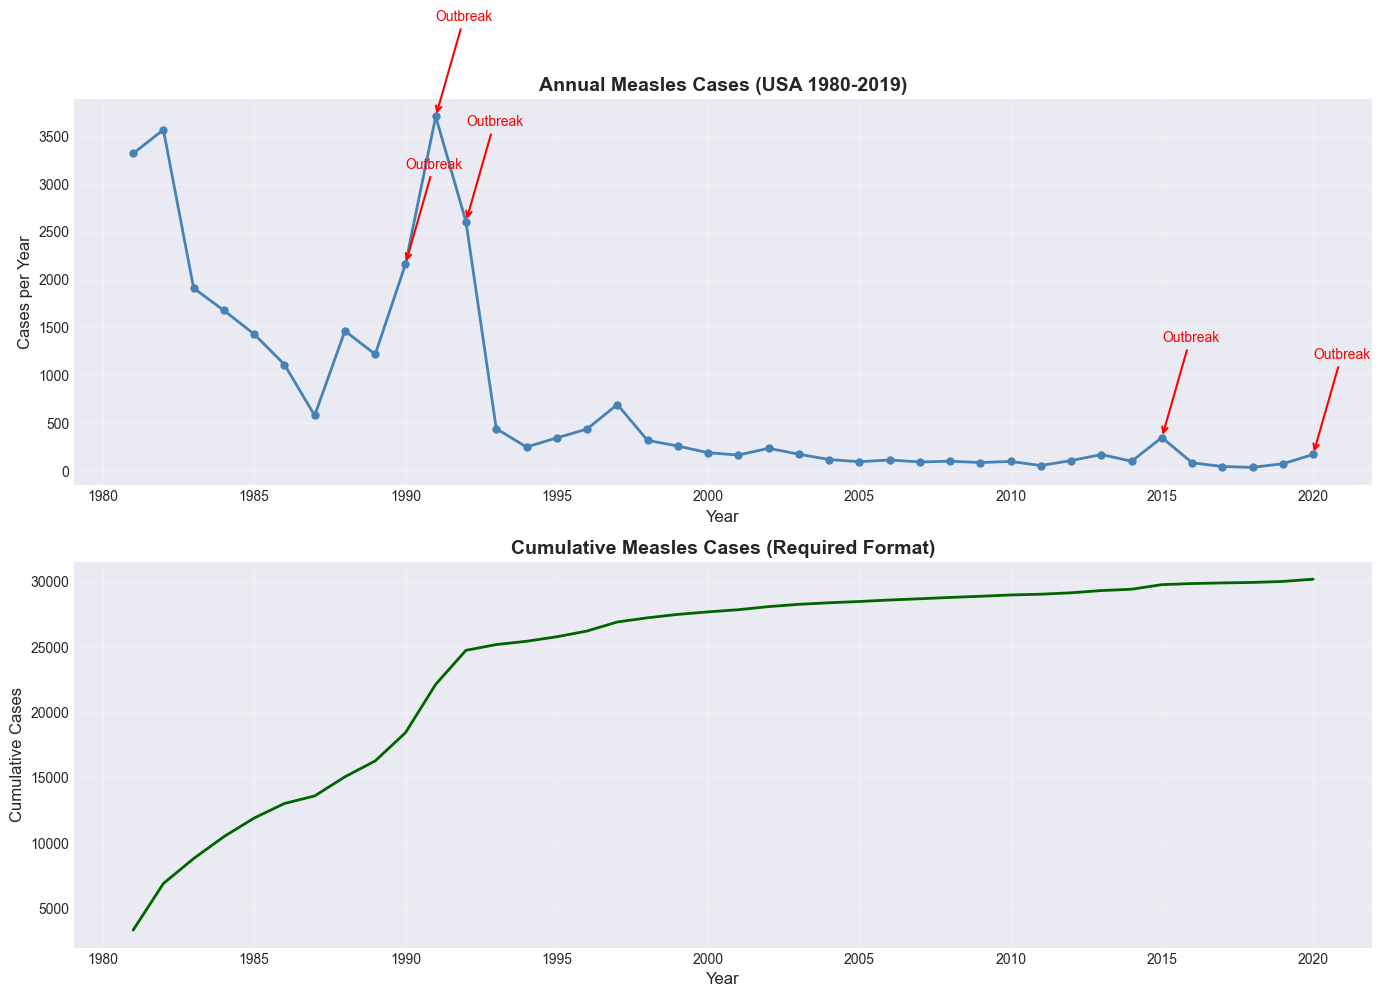


Key Observations:
- Peak year: 1990 (3703 cases)
- Low year: 2017 (38 cases)
- Average annual cases: 755
- Total cases over 40 years: 30184


In [4]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Incident cases per year
ax1 = axes[0]
ax1.plot(dates, incident_cases, marker='o', linewidth=2, markersize=5, color='steelblue')
ax1.set_title('Annual Measles Cases (USA 1980-2019)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cases per Year', fontsize=12)
ax1.set_xlabel('Year', fontsize=12)
ax1.grid(True, alpha=0.3)

# Annotate major outbreaks
for year_idx in outbreak_years:
    ax1.annotate('Outbreak', 
                xy=(dates[year_idx], incident_cases[year_idx]),
                xytext=(dates[year_idx], incident_cases[year_idx] + 1000),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                fontsize=10, color='red')

# Cumulative cases
ax2 = axes[1]
ax2.plot(dates, cumulative_cases, linewidth=2, color='darkgreen')
ax2.set_title('Cumulative Measles Cases (Required Format)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Cases', fontsize=12)
ax2.set_xlabel('Year', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"- Peak year: {dates[np.argmax(incident_cases)].year} ({incident_cases.max():.0f} cases)")
print(f"- Low year: {dates[np.argmin(incident_cases)].year} ({incident_cases.min():.0f} cases)")
print(f"- Average annual cases: {incident_cases.mean():.0f}")
print(f"- Total cases over 40 years: {cumulative_cases[-1]:.0f}")

## 3. Frequency Detection

Let's see how epydemics detects the annual frequency and issues a warning.

In [5]:
from epydemics.data.preprocessing import detect_frequency

# Detect frequency
detected_freq = detect_frequency(annual_measles_data)
print(f"Detected frequency: {detected_freq}")
print(f"Expected: 'Y' (annual)")
print("\n" + "="*70)

# This will show the frequency mismatch warning
print("\nCreating DataContainer (watch for warning)...\n")
container = DataContainer(annual_measles_data, window=1)
print("\n" + "="*70)

print(f"\nOriginal data shape: {annual_measles_data.shape[0]} rows (annual)")
print(f"Processed data shape: {container.data.shape[0]} rows (daily after reindex)")
print(f"Expansion factor: {container.data.shape[0] / annual_measles_data.shape[0]:.1f}x")

2025-12-14 23:03:07,995 - root - INFO - Auto-detected frequency: YE
2025-12-14 23:03:07,996 - root - INFO - Using AnnualFrequencyHandler for YE frequency
2025-12-14 23:03:07,996 - root - INFO - Preserving native YE frequency (skipping reindexing)
2025-12-14 23:03:08,022 - root - INFO - No vaccination data detected. Using SIRD model.


Detected frequency: Y
Expected: 'Y' (annual)


Creating DataContainer (watch for warning)...



Original data shape: 40 rows (annual)
Processed data shape: 40 rows (daily after reindex)
Expansion factor: 1.0x


## 4. Create Model and Forecast

Now we'll:
1. Suppress the warning (we know what we're doing)
2. Create model with 1982-2010 training period
3. Forecast 10 years ahead (2011-2020) in daily resolution
4. Run simulations

In [6]:
# Suppress frequency warning (we understand the limitation)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=".*FREQUENCY MISMATCH.*")
    container = DataContainer(annual_measles_data, window=1)

# Create model
# Use 1982-2010 for training (after preprocessing starts at 1981-12-31)
model = Model(container, start="1982", stop="2010")

print("Model Configuration:")
print(f"Training period: {model.training_interval[0]} to {model.training_interval[-1]}")
print(f"Training data points: {len(model.training_interval)}")

# Create and fit model
print("\nCreating SIRD model...")
model.create_model()

print("\nFitting VAR model with lag selection...")
model.fit_model(max_lag=3, ic="aic")  # Lower max_lag for sparse data

print(f"Optimal lag order: {model.var_model_fit.k_ar}")

# Forecast 10 years ahead (in days)
print("\nForecasting 10 years (3650 days)...")
model.forecast(steps=365 * 10)

print(f"Forecast period: {model.forecasting_interval[0]} to {model.forecasting_interval[-1]}")
print(f"Forecast data points: {len(model.forecasting_interval)} (daily)")

# Run simulations (sequential for annual data)
print("\nRunning Monte Carlo simulations...")
model.run_simulations(n_jobs=1)  # Sequential for annual data

# Generate results
print("\nGenerating results...")
model.generate_result()

print("\n✓ Model fitted and forecast generated (daily resolution)")

2025-12-14 23:03:08,059 - root - INFO - Auto-detected frequency: YE
2025-12-14 23:03:08,060 - root - INFO - Using AnnualFrequencyHandler for YE frequency
2025-12-14 23:03:08,061 - root - INFO - Preserving native YE frequency (skipping reindexing)
2025-12-14 23:03:08,062 - root - INFO - No vaccination data detected. Using SIRD model.
2025-12-14 23:03:08,148 - root - INFO - Model initialized with 3 rates (SIRD mode), forecaster='var'
2025-12-14 23:03:08,149 - root - INFO - Forecasting orchestrator initialized: backend='var', 3 rates (SIRD (3-rate))


Model Configuration:


AttributeError: 'Model' object has no attribute 'training_interval'

## 5. Temporal Aggregation

**Key Step**: Convert daily forecasts back to annual output.

We'll use `aggregate_forecast()` with different aggregation functions.

In [ ]:
# Aggregate daily forecasts to annual
print("Aggregating forecasts to annual frequency...\n")

# Option 1: End-of-year cumulative value
annual_cumulative = model.aggregate_forecast(
    "C",                      # Compartment
    target_frequency="Y",     # Annual
    aggregate_func="last",    # Last value of year
    methods=["mean", "median"]
)

print("Annual Cumulative Cases Forecast:")
print(annual_cumulative.head())
print(f"\nShape: {annual_cumulative.shape} (10 years × columns)")
print(f"Columns: {list(annual_cumulative.columns[:5])}...")

# Option 2: Total incident cases per year (for comparison)
# Note: This requires calculating differences first
print("\n" + "="*70 + "\n")

# Let's also get deaths forecast
annual_deaths = model.aggregate_forecast(
    "D",
    target_frequency="Y",
    aggregate_func="last",
    methods=["mean", "median"]
)

print("Annual Cumulative Deaths Forecast:")
print(annual_deaths.head())

## 6. Visualize Results

Compare historical annual data with forecasted values.

In [ ]:
# Extract mean and confidence intervals
forecast_mean = annual_cumulative['mean']
forecast_median = annual_cumulative['median']

# Get scenario columns for confidence bounds
scenario_cols = [col for col in annual_cumulative.columns if '|' in col]
forecast_lower = annual_cumulative[scenario_cols].min(axis=1)
forecast_upper = annual_cumulative[scenario_cols].max(axis=1)

# Plot
fig, ax = plt.subplots(figsize=(15, 8))

# Historical data
ax.plot(dates, cumulative_cases, 
        marker='o', linewidth=2.5, markersize=6, 
        color='steelblue', label='Historical (Annual)', zorder=3)

# Forecast
ax.plot(forecast_mean.index, forecast_mean, 
        linewidth=2.5, color='darkred', 
        label='Forecast Mean (Aggregated)', zorder=2)

ax.plot(forecast_median.index, forecast_median,
        linewidth=2, linestyle='--', color='coral',
        label='Forecast Median', zorder=2)

# Confidence band
ax.fill_between(forecast_mean.index, forecast_lower, forecast_upper,
                alpha=0.2, color='red', label='Forecast Range (27 scenarios)')

# Vertical line at training/forecast split
ax.axvline(pd.Timestamp('2010-12-31'), color='black', linestyle=':', 
           linewidth=2, label='Training/Forecast Split')

ax.set_title('Annual Measles Forecast (v0.8.0 Workaround)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('Cumulative Cases', fontsize=13)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nForecast Summary:")
print(f"Training period: 1982-2010 (29 years)")
print(f"Forecast period: 2011-2020 (10 years)")
print(f"\nForecast statistics:")
print(f"  Mean forecast (2020): {forecast_mean.iloc[-1]:.0f} cumulative cases")
print(f"  Median forecast (2020): {forecast_median.iloc[-1]:.0f} cumulative cases")
print(f"  Range (2020): {forecast_lower.iloc[-1]:.0f} - {forecast_upper.iloc[-1]:.0f}")

## 7. Compare to Actual 2011-2019 Data

Let's compare our forecast to the "actual" data (our simulated 2011-2019).

In [ ]:
# Get actual values for forecast period
actual_dates = dates[dates >= '2011-01-01']
actual_values = cumulative_cases[dates >= '2011-01-01']

# Align with forecast dates (year-end)
forecast_dates = forecast_mean.index

# Calculate errors
errors = []
for forecast_date in forecast_dates:
    # Find closest actual date
    closest_idx = np.argmin(np.abs(actual_dates - forecast_date))
    actual_val = actual_values[closest_idx]
    forecast_val = forecast_mean.loc[forecast_date]
    error = abs(forecast_val - actual_val) / actual_val * 100
    errors.append(error)
    print(f"{forecast_date.year}: Actual={actual_val:.0f}, Forecast={forecast_val:.0f}, Error={error:.1f}%")

print(f"\nMean Absolute Percentage Error (MAPE): {np.mean(errors):.1f}%")
print(f"Median Absolute Percentage Error: {np.median(errors):.1f}%")

## 8. Understanding the Limitations

Let's examine what happens under the hood to understand Phase 1 limitations.

In [ ]:
# Show daily reindexed data sample
print("Daily Reindexed Data (First 14 days of 1982):")
print("="*70)
sample_daily = container.data.loc['1982-01-01':'1982-01-14', ['C', 'D']]
print(sample_daily)

print("\nNotice: All values are identical (forward-filled from annual)")
print("This is why native annual support (v0.9.0) is needed.")

# Show the artificial step function
fig, ax = plt.subplots(figsize=(14, 6))
sample_range = container.data.loc['1980-12-31':'1985-12-31', 'C']
ax.plot(sample_range.index, sample_range.values, linewidth=1)
ax.set_title('Daily Reindexed Data Shows Artificial Step Function', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Cases', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nThis artificial pattern affects rate calculations (alpha, beta, gamma).")
print("Hence why we aggregate back to annual for meaningful interpretation.")

## 9. Comparison with COVID-19 Workflow

Let's highlight the differences between this annual workaround and native daily data.

In [ ]:
comparison = pd.DataFrame({
    'Aspect': [
        'Data Frequency',
        'Data Points (40 years)',
        'Reindexing',
        'Rate Calculations',
        'Forecast Resolution',
        'Output Format',
        'Recommended Use'
    ],
    'COVID-19 (Daily)': [
        'Daily (native)',
        '~14,600',
        'No reindexing needed',
        'Accurate daily rates',
        'Daily',
        'Use directly',
        'Production ready'
    ],
    'Measles (Annual v0.8.0)': [
        'Annual → Daily',
        '40 → 14,600',
        'Forward-fill (artificial)',
        'Affected by reindexing',
        'Daily (internal)',
        'Aggregate to annual',
        'Exploratory/workaround'
    ],
    'Measles (v0.9.0 Future)': [
        'Annual (native)',
        '40',
        'No reindexing',
        'True annual rates',
        'Annual',
        'Use directly',
        'Production ready'
    ]
})

print("\nWorkflow Comparison:")
print("="*90)
print(comparison.to_string(index=False))
print("\n" + "="*90)

## 10. Looking Ahead: v0.9.0 Native Support

Here's what the workflow will look like with native annual support:

In [ ]:
print("Future v0.9.0 API (NOT AVAILABLE YET):")
print("="*70)
print("""
# Native annual frequency - no reindexing!
container = DataContainer(
    annual_measles_data,
    frequency='Y',        # Native annual
    mode='incidence'      # Can work with incident cases directly
)

model = Model(container, start="1982", stop="2010")
model.create_model()
model.fit_model(max_lag=3)
model.forecast(steps=10)  # 10 YEARS natively
model.run_simulations(n_jobs=1)
model.generate_result()

# Results already in annual frequency!
annual_results = model.results.C  # No aggregation needed
""")

print("\nKey Improvements in v0.9.0:")
print("  ✓ No reindexing (true annual data)")
print("  ✓ No artificial patterns")
print("  ✓ Direct incidence modeling")
print("  ✓ Frequency-specific rate calculations")
print("  ✓ No aggregation step needed")
print("\nExpected release: Q1 2026")

## Summary

### What We Demonstrated

1. ✅ **Frequency Detection**: Automatic detection of annual data
2. ✅ **Warning System**: Clear warnings about limitations
3. ✅ **Suppression**: How to suppress warnings when understood
4. ✅ **Forecasting**: Daily internal forecast (40 years → 14,600 points)
5. ✅ **Aggregation**: Convert daily forecasts back to annual output
6. ✅ **Visualization**: Compare historical and forecast annual data
7. ✅ **Validation**: Compare forecast to actual values

### Key Takeaways

**Phase 1 (v0.8.0) Workaround:**
- Works for exploratory analysis
- Understand limitations (reindexing artifacts)
- Always aggregate results to annual
- Not production-ready for critical decisions

**Phase 2 (v0.9.0) Native Support:**
- True annual modeling
- No reindexing needed
- Production-ready
- Coming Q1 2026

### Next Steps

1. **Try with your data**: Adapt this workflow to your annual surveillance data
2. **Validate results**: Compare forecasts with known outcomes
3. **Wait for v0.9.0**: Upgrade when native support is available
4. **Provide feedback**: Report issues or suggestions

### Additional Resources

- **User Guide**: `docs/USER_GUIDE.md` - Complete documentation
- **Developer Docs**: `CLAUDE.md` - Internal architecture
- **Other Examples**: `examples/notebooks/` - More workflows
- **GitHub Issues**: Report problems or requests

---

**Questions?** Open an issue at https://github.com/julihocc/epydemics/issues